## I) Indéxation / Vérification des éléments du jeu de données

In [1]:
import torch
from torch.utils.data import DataLoader,Dataset,Subset
from utils import My_dataset,train_val_dataset,split_A,plot_train_test_loss,apply_LPALM_realistic

import matplotlib.pyplot as plt
import matplotlib
import pylab
from train import train_non_blind,train_blind
from ISTA import ISTA
from PALM import PALM
from LISTA import LISTA
import argparse
import numpy as np
import torch.nn as nn
import pickle

import copy as cp
from utils import prox_l1, prox_oblique
import scipy.io

#Nécessaires pour la génération de cartes d'abondances
from numpy import linalg as LA
from scipy.stats import gennorm
from torch.utils.data import Dataset,Subset
from scipy.stats import norm
from random import shuffle
from sklearn.model_selection import train_test_split
import math
import pandas as pd
import seaborn as sns
from numpy import random

from sklearn.model_selection import train_test_split

## II) Génération d'un nouveau jeu de données  [Samson]

##### Données de ground truth

In [2]:
mat = scipy.io.loadmat('X_samson_normalized')
data = list(mat.items())
an_array = np.array(data,dtype=object)
X_samson_normalized = an_array[3,1]
#Tensor
#X_samson_normalized = torch.reshape(torch.tensor(X_samson_normalized),[1,156,9025])

In [3]:
mat = scipy.io.loadmat('A_samson_normalized')
data = list(mat.items())
an_array = np.array(data,dtype=object)
A_samson_normalized = an_array[3,1]
#Tensor
#A_samson_normalized = torch.reshape(torch.tensor(A_samson_normalized),[1,156,3])

In [4]:
mat = scipy.io.loadmat('S_samson')
data = list(mat.items())
an_array = np.array(data,dtype=object)
S_samson = an_array[3,1].T
#Tensor
#S_samson = torch.reshape(torch.tensor(S_samson),[1,3,9025])

##### Données estimées (SNPA)

In [5]:
mat = scipy.io.loadmat('A_snpa')
data = list(mat.items())
an_array = np.array(data,dtype=object)
A_snpa = an_array[3,1]

In [6]:
mat = scipy.io.loadmat('S_snpa')
data = list(mat.items())
an_array = np.array(data,dtype=object)
S_snpa = an_array[3,1]

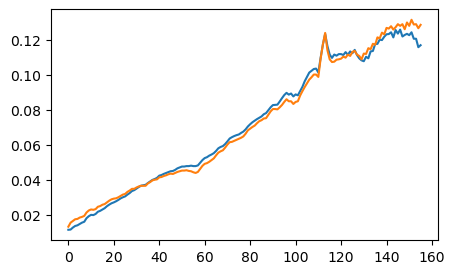

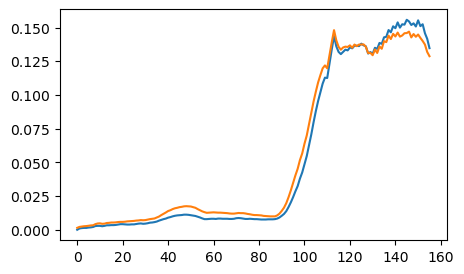

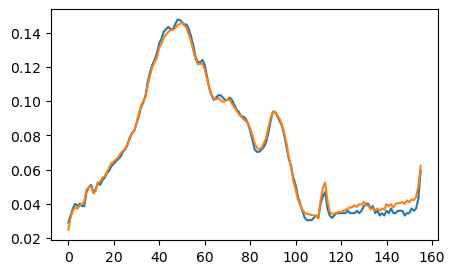

In [7]:
#Comparaison des spectres comparées et spectes estimés
#Soil
plt.figure(figsize=(5,3))
plt.plot(A_snpa[:,0])
plt.plot(A_samson_normalized[:,0])

#Tree
plt.figure(figsize=(5,3))
plt.plot(A_snpa[:,1])
plt.plot(A_samson_normalized[:,1])

#Water
plt.figure(figsize=(5,3))
plt.plot(A_snpa[:,2])
plt.plot(A_samson_normalized[:,2])

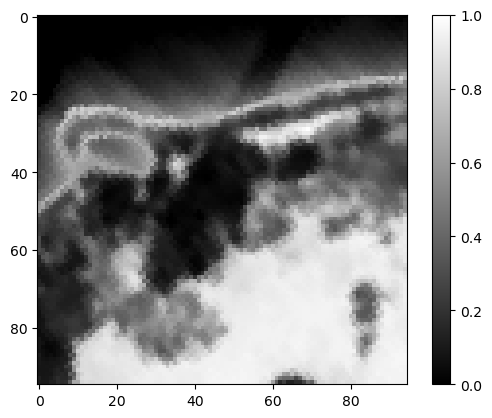

In [8]:
#Affichage des carte d'abondance
#S_samson
i=0
plt.imshow(S_snpa.reshape([3,95,95])[i],vmin=0, vmax=1, cmap='gray')
plt.colorbar()

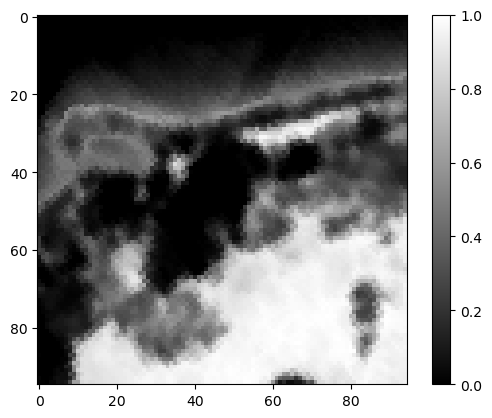

In [9]:
#Affichage des carte d'abondance
#S_samson
plt.imshow(S_samson.T.reshape([3,95,95])[i],vmin=0, vmax=1, cmap='gray')
plt.colorbar()

Remarque: Il y a bien une cohérence entre les endmember de A et de S (si besoin se référer aux informations sur le jeu de données), ainsi qu'une différence entre S_samson et S_snpa.

### Génération de cartes d'abondances pour Samson:

In [10]:
def generation_abundance_maps(eps, theta, N):
    #eps: vecteur des probas associées au modèle de mélange
    #theta: vecteur des paramètres du mélange de Dirichlet
    #N: taille de la carte d'abondance souhaitée
    
    proportion = eps*N #Vecteur dans lequel on va stocker le nombre d'échantillon associé à chaque mélange
    proportion = [int(x) for x in proportion] #on prend la partie entière (veilleur à ajuster pour N adéquat)
    
    size_samples = sum(proportion)
    
    #Génération de Samples issus des lois estimées
    Samples = np.zeros((N,3))
    k = proportion[0]
    
    for j in range(k):
        Samples[j] = np.random.dirichlet(theta[0])
    
    position = 0
    for i in range(1,len(proportion)):
        position += proportion[i-1]
        
        for j in range(position,position+proportion[i]):
            Samples[j] = np.random.dirichlet(theta[i])
    
    #Pour combler le vide du aux nombres entiers
    for l in range(size_samples,N):
        Samples[l] = np.random.dirichlet(theta[1])
    
    return Samples

In [11]:
#On charge les paramètres de samson:
eps_samson = np.asarray([0.13205243, 0.12233268, 0.24129023, 0.18718084, 0.01888313, 
                    0.01271258, 0.14945541, 0.1360927 ])

theta_samson = np.asarray([[ 0.60330514, 32.65955297,  0.31616308],
                      [ 3.54583748,  0.39165915, 10.48946963],
                      [14.60738504,  1.04699353,  0.38345853],
                      [ 8.07210197,  9.43537876,  0.35494726],
                      [17.90846706,  4.62227334, 15.32817447],
                      [18.39763392, 15.85345466, 10.18199521],
                      [ 4.54381057, 19.21862903,  0.28645229],
                      [ 0.43481026,  0.29522029, 24.39660685]])

In [12]:
#Génération d'un exemple de jeu de données et comparaison des histogrammes pour vérification
generated_sample = generation_abundance_maps(eps_samson, theta_samson, 9025)

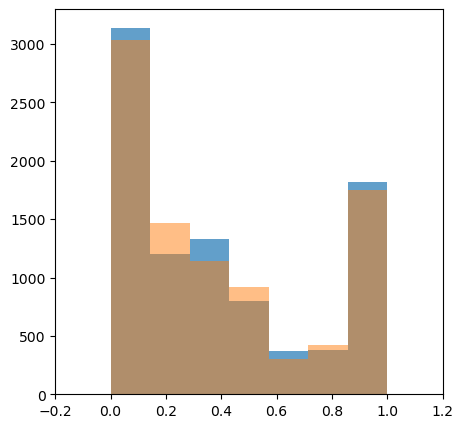

In [15]:
#Superposition des histogrammes
i = 0
plt.figure(figsize=(5,5))
bins = 8

#Original data (Blue)
plt.hist(S_samson[:,i], bins=np.linspace(0, 1, num=bins), alpha = 0.7) #np.linspace(0,1,num=12)); #80

#Fitted data (Orange)
plt.hist(generated_sample[:,i], bins=np.linspace(0, 1, num=bins), alpha = 0.5) #np.linspace(0,1,num=12)); #120

plt.xlim([-0.2,1.2])
plt.show()

### Génération de spectres pour Samson:

In [16]:
#Génération de variabilités spectrales:
def affine_piece_wise(c_var,L):
    
    #Fonction qui donne les coordonnées nécessaires à la fct continue par morceaux
    
    #c_var: variability coefficient
    #L: Nummber of channels 
    xi_1 = np.random.uniform(low=1-c_var/2, high=1+c_var/2, size=None)
    xi_2 = np.random.uniform(low=1-c_var/2, high=1+c_var/2, size=None)
    xi_3 = np.random.uniform(low=1-c_var/2, high=1+c_var/2, size=None)
    U = np.random.normal(loc=0.0, scale=1.0, size=None)
    
    if U > 3/2 or U < -1.4: #Après calcul de l'intervalle
        L_break = int(np.floor(L/2))
    else:
        L_break = int( np.floor(L/2 + np.floor(L*U/3)) ) 
    
    return xi_1, xi_2, xi_3, L_break

In [17]:
def perturbated_spectrum(spectrum, c_var, L):
    #Fonction qui à partir des coordonnées de affine_piece_wise, établi la perturbation (produit)
    
    #spectrum: the spectra to which we'll apply the perturbation
    #c_var: variability coefficient
    #L: Nummber of channels
    xi_1, xi_2, xi_3, L_break = affine_piece_wise(c_var,L)
    
    #Calcul des coefficients directeurs et des ordonnées à l'origine des 2 fcts affines 
    a_1 = (xi_2-xi_1)/(L_break-1)
    c_1 = (xi_1-1*a_1)

    a_2 = (xi_3-xi_2)/(L-L_break)
    c_2 = (xi_3-L*a_2)
    
    #Calcul de la perturbation
    perturbation = [i for i in range(1,L+1)]
    
    for i in range(L_break):
        perturbation[i] = a_1*(i+1) + c_1
    for i in range(L_break,L):
        perturbation[i] = a_2*(i+1) + c_2
    
    #Application de la perturbation
    spectrum_modified = (spectrum.clone()).detach().numpy() # spectrum.copy() #Dépend de l'utilisation
    
    for i in range(L):
        spectrum_modified[i] = spectrum_modified[i]*perturbation[i]
        
    #Normalisation de ces spectres dans la boule L2 (sphère)
    if sum(spectrum_modified*spectrum_modified) > 1:
        spectrum_modified /= np.linalg.norm(spectrum_modified)
        
    return spectrum_modified

In [18]:
#Génération de sample perturbé:
i=1
L=156
c_var = 0.4

#Les estimations de SNPA
spectrum1 = torch.tensor(A_snpa[:,0])
spectrum2 = torch.tensor(A_snpa[:,1])
spectrum3 = torch.tensor(A_snpa[:,2])

#Les 
Simu_samson_1 = np.zeros((200,156))
Simu_samson_2 = np.zeros((200,156))
Simu_samson_3 = np.zeros((200,156))

for i in range(200):
    generated_s1 = perturbated_spectrum(spectrum1, c_var, L)
    #Simu_samson_1[i] = generated_s1/sum(generated_s1) #=> Erreur
    Simu_samson_1[i] = generated_s1/np.linalg.norm(generated_s1) #Modification (normalisation sphere L2)
    
    
    generated_s2 = perturbated_spectrum(spectrum2, c_var, L)
    #Simu_samson_2[i] = generated_s2/sum(generated_s2) #=> Erreur
    Simu_samson_2[i] = generated_s2/np.linalg.norm(generated_s2) #Modification (normalisation sphere L2)
    
    generated_s3 = perturbated_spectrum(spectrum3, c_var, L)
    #Simu_samson_3[i] = generated_s3/sum(generated_s3) #=> Erreur
    Simu_samson_3[i] = generated_s3/np.linalg.norm(generated_s3) #Modification (normalisation sphere L2)
    
    #print(np.linalg.norm(generated_s1), np.linalg.norm(generated_s2), np.linalg.norm(generated_s3))
    #print(np.linalg.norm(Simu_samson_1[i]), np.linalg.norm(Simu_samson_2[i]), np.linalg.norm(Simu_samson_3[i]))

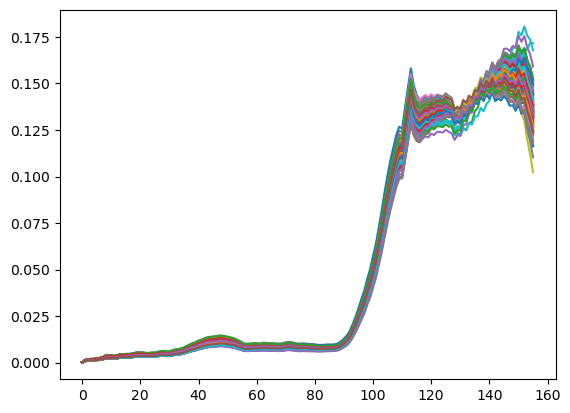

In [19]:
for i in range(156):
    plt.plot(Simu_samson_2[i]);

In [ ]:
#Vérification que la norme fasse bien 1
for i in range(200):
    print(np.linalg.norm(Simu_samson_3[i]))

In [22]:

def mixing(t = 9025, noise=True, SNR=30, normalize_S_lines = False): #False #625 = 25x25 taille des patchs
#def mixing(t = 10000, noise=True, SNR=30, normalize_S_lines = True, theta = 5): #False
	A1,A2,A3 = Simu_samson_1,Simu_samson_2,Simu_samson_3
	X = np.zeros((A1.shape[0],A1.shape[1],t))
	A = np.zeros((A1.shape[0],A1.shape[1],3)) #4
	S = np.zeros((A1.shape[0],3,t)) #4

    
	for i in range(A1.shape[0]): #0,200,2): 
		A[i] = np.concatenate((A1[i].reshape(-1,1),A2[i].reshape(-1,1),A3[i].reshape(-1,1)), axis = 1)

            
#		S[i] = generation_abundance_maps(eps_samson, theta_samson, 9025).T #(np.reshape(data, [t,4])).T
		S[i] = S_samson.T
    
		if normalize_S_lines:
			for j in range(S.shape[1]):
				S[i][j,:] = S[i][j,:]/np.linalg.norm(S[i][j,:]) 
                
		X[i] = np.matmul(A[i],S[i])
		if noise:
			noise_level = SNR
			N = np.random.randn(X[i].shape[0],X[i].shape[1])
			N = 10.**(-noise_level/20.)*np.linalg.norm(X[i])/np.linalg.norm(N)*N
			X[i] = X[i] + N
            
		#On ajoute une normalisation de X (de sorte à reproduire le schéma IRL)
		for c in range(t):
			X[i,:,c] = X[i,:,c]/np.linalg.norm(X[i,:,c])
            
	return (X,A,S)           

In [23]:
X,A,S = mixing(t = 9025, noise=True, SNR=30, normalize_S_lines = False) #, theta=3)

In [199]:
#Verification que les normes des colonnes des X formés sont cohérentes 
for i in range(200):
    print(min(np.linalg.norm(X[i], axis=0)))
    #print(min(np.linalg.norm(A[i]@S[i], axis=0)))

In [179]:
min(np.linalg.norm(A_snpa@S_snpa, axis=0))

0.9113567043120537

In [182]:
min(np.linalg.norm(A_samson_normalized@S_samson.T, axis=0))

0.8789063884052806

### Création du dataset

In [24]:
from torch.utils.data import Dataset,Subset
from torch.utils.data import DataLoader,Dataset

#On rappelle la classe My_data_set
class My_dataset(Dataset):
	def __init__(self, t = 9025, noise=True, SNR=30, normalize_S_lines = True):#, theta=3):
		self.X, self.A, self.S = mixing(t, noise, SNR= SNR, normalize_S_lines= normalize_S_lines)

	def __getitem__(self, item):
		return self.X[item], self.A[item], self.S[item]
    
	def __len__(self):
		return len(self.X)

In [25]:
dataset_samson = My_dataset(t = 9025, noise=True, SNR=30, normalize_S_lines = False)

In [26]:
print(f" Le jeu de données est composé de {np.shape(dataset_samson)[0]} samples")
print(f" Le jeu de données est composé de {np.shape(dataset_samson)[1]} sorties")

print(f" la taille d'un sample de X:{np.shape(dataset_samson[0][0])}")
print(f" la taille d'un sample de A:{np.shape(dataset_samson[0][1])}")
print(f" la taille d'un sample de S:{np.shape(dataset_samson[0][2])}")

 Le jeu de données est composé de 200 samples
 Le jeu de données est composé de 3 sorties
 la taille d'un sample de X:(156, 9025)
 la taille d'un sample de A:(156, 3)
 la taille d'un sample de S:(3, 9025)


/home/rassim/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [27]:
#Division du jeu de données en train et test
train_set, val_set = train_test_split(dataset_samson, test_size=0.25, random_state=42)

In [28]:
#Sauvegarde du jeu de données "jeu" en tant que pickle:
import pickle 

with open('samson_train_set.pickle', 'wb') as f:
    pickle.dump(train_set, f)
    
with open('samson_val_set.pickle', 'wb') as f:
    pickle.dump(val_set, f)